[Previous](https://github.com/biocore/gneiss/blob/master/ipynb/cfstudy.ipynb)

Here, we will apply balance trees to phylogenetic trees.  Note that this technique has already been extensively explored [here](http://biorxiv.org/content/biorxiv/early/2016/08/31/072413.full.pdf).

For this case study, we will be exploring the application of balance trees to analyze mice inflicted with Post Traumatic stress (PTSD).  There are 4 groups of mice CSC-MVAC, CSC-VEH, SHC-MVAC, SHC-VEH.
The CSC-MVAC group consist of mice that were placed in a cage with a dominant male mouse, which was supposed to induce stress.  These mice were also treated with M. vaccae, which was hypothesized to help treat the trauma induced by the dominant male.  The CSC-VEH group consists of mice placed in the cage with a dominant male mouse, but treated with a placebo instead of M. vaccae.  The SHC-MVAC group consists of mice placed in a single cage separate from the dominant male mouse, but treated with M. vaccae.  The SHC-VEH group consists of mice placed in a single cage separate from the dominant male mouse, but treated with a placebo.  Fecal pellets from these mice were collected over the course of 6 weeks.  The CSC mice were placed in the cage with the dominant male mouse at week 3.  

The goal of this study was to (1) identify if there is a microbial shift due to stress and (2) determine if the application of M. vaccae can reverse this effect.

The original study can be found [here](http://www.ncbi.nlm.nih.gov/pubmed/27185913)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import ilr, ilr_inv
from skbio import TreeNode
from gneiss.balances import balanceplot, balance_basis
from gneiss.util import match_tips, match, rename_internal_nodes
from biom import load_table
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
import warnings
import copy
from gneiss import mixedlm
# Only to ignore warnings in linear mixed models code block.
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
table = load_table('data/otu_table.biom')
mapping = pd.read_table('data/1634_prep_1699_qiime_20160501-005436.txt', 
                        index_col=0, na_values=['not applicable'])
tree = TreeNode.read('97_otus.tree') 

For now, we'll be dropping blanks. So any samples that don't contain any indication of the treatment type will be dropped.  We'll also be filtering out low abundance OTUs (i.e. OTUs that have less than 100 reads in all of the samples), spurious OTUs (i.e. OTUs that aren't present in 25% of the samples), and samples that contain less than 2000 reads.

In [3]:
mapping = mapping.dropna(subset=['stressed'])

sample_filter = lambda val, id_, md: sum(val) > 2000
read_filter = lambda val, id_, md: sum(val) > 100
sparse_filter = lambda val, id_, md: sum(val>0)/len(val)> 0.25

md_filter = lambda val, id_, md:  id_ in mapping.index
table.filter(md_filter, axis='sample')
table.filter(sample_filter, axis='sample')
table.filter(sparse_filter, axis='observation')
table.filter(read_filter, axis='observation')

1091 x 261 <class 'biom.table.Table'> with 170279 nonzero entries (59% dense)

We'll want to define two helper methods `convert_biom_to_pandas` and `ladderize`.  We'll need the `convert_biom_to_pandas` to be able to read the biom tables as pandas dataframes.  This is advantagenous, since we can take advantage of the wide array of speedy, table manipulation operations offered by pandas.  The `ladderize` function is purely for the sake of tree visualization - it rotates all of the trees such that the largest subtrees are place on the bottom, basically sorting the tree by increasing subtree size.

In [4]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    table : pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    taxonomy : pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """
    otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    otu_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in otu_ids}
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return otu_table, taxonomy

def ladderize(tree):
    """
    Sorts tree according to the size of the subtrees.
    
    Parameters
    ----------
    tree : skbio.TreeNode
       Input tree where leafs correspond to features
       contained in the index in `grouping1.
    gradient : pd.Series
       Gradient where the index correspond to features.
    
    Returns
    -------
    skbio.TreeNode
       A tree whose tips are sorted along the gradient.
    """
    sorted_tree = tree.copy()
    for n in sorted_tree.postorder(include_self=True):
        sizes = [len(list(k.tips())) for k in n.children]
        idx = np.argsort(sizes)
        n.children = [n.children[i] for i in idx]
    return sorted_tree


There is still a bit of boiler plate code required to tweeze out the balances and visualize them.   However, these exact steps are performed within the `mixedlm` functions (with the exception of `ladderize`).
So these following steps can be skipped if only the pvalues were to be obtained and plotted on a tree through `balanceplot`.  But here, we will want to investigate each of the interesting balances, so we'll need a way to extract
the appropriate balances for plotting later.

In [5]:
# obtain taxonomy table and OTU table as pandas DataFrames
otu_table, taxonomy = convert_biom_to_pandas(table)

# sort the columns of the OTU table to match up with the tree tips
otu_table, otu_tree = match_tips(otu_table, tree) 

# sort the rows of the OTU table to match up with the metadata rows
otu_table, mapping = match(otu_table, mapping)

# sorts the tree by increasing subtree size. Mainly for visualization.
otu_tree = ladderize(otu_tree) 

# reorder the columns of the table according to the order of the tips of the tree.
# this is required since the tree tips are now in a different order due to the
# ladderize function.
otu_table, otu_tree = match_tips(otu_table, otu_tree) 

Recall that Greengenes has both bacterial and archaea 16S sequences, but here there are no Archaea species.  This means that the root of the tree will have only 1 child corresponding to the Bacterial kingdom.  This is problematic since balance trees can only work on strictly bifurcating trees (i.e. every internal node has to have exactly 2 children).  To fix this, the root node can be knocked off, and replaced with its child.

In [6]:
# This has been fixed in scikit-bio 0.5.0.  This will be removed in the next major release of scikit-bio
otu_tree = otu_tree.children[0]
otu_tree.parent = None

# rename the tree according to the level ordering of the tree.  For instance, the root 
# node would be labeled y0, and its children would be labeled y1 and y2, etc ...
otu_tree = rename_internal_nodes(otu_tree)

Now we can run the linear mixed effects model (LME).  This basically runs an LME on each balance individually.
Here, we have specified a model equation made up of `collection_day`, `mvac` and `csc`.  Here, we are testing the
interaction effect of `mvac` and `csc` in addition to their main effects.  Also note that LMEs are designed for longitudinal data, capturing the effect of `collection_day`.

In [7]:
res = mixedlm("collection_day + C(mvac) * C(csc)",
              otu_table+1, mapping, otu_tree,
              groups='host_subject_id') 

The LME returns a summary object.  This object contains information about the coefficients and pvalues.  See the 
[RegressionResults](https://github.com/biocore/gneiss/blob/master/gneiss/_summary.py) object for more details on this.  We'll start off by scanning the top 15 smallest pvalues respect to `collection_day` and `csc`. Note that the variable names are due to the naming scheme of patsy, which is use to parse the formula strings.

In [8]:
res.pvalues.sort_values(by='collection_day').iloc[:15]

,C(csc)[T.True],C(mvac)[T.True],C(mvac)[T.True]:C(csc)[T.True],Intercept,Intercept RE,collection_day
y267,0.039286,0.265848,0.882425,3.982787e-28,0.000016,9.099492e-37
y33,0.000322,0.720159,0.727647,5.939125e-12,0.000066,2.895135e-33
y4,0.014826,0.093359,0.409892,2.320190e-01,0.000028,2.787433e-31
y263,0.002320,0.415780,0.418922,1.069291e-02,0.000005,9.785406e-31
y291,0.006885,0.280249,0.750703,1.702736e-33,0.000058,1.976926e-27
y914,0.425758,0.333660,0.186973,3.188419e-14,0.000002,5.582189e-27
y794,0.191980,0.198537,0.736331,1.037373e-10,0.999687,2.083131e-24
y59,0.279176,0.691100,0.230889,2.236178e-01,0.001482,3.295178e-24
y246,0.083853,0.279546,0.195659,3.228511e-12,0.000328,3.313618e-23
y436,0.103439,0.111350,0.524601,6.419449e-77,0.000636,4.464054e-22


In [9]:
res.pvalues.sort_values(by='C(csc)[T.True]').iloc[:15]

,C(csc)[T.True],C(mvac)[T.True],C(mvac)[T.True]:C(csc)[T.True],Intercept,Intercept RE,collection_day
y7,0.000096,0.483184,0.478766,8.135831e-07,0.000009,7.435943e-21
y333,0.000107,0.643043,0.137974,2.321015e-07,0.000044,2.959380e-06
y939,0.000130,0.011895,0.003632,1.180542e-04,0.999945,9.755482e-01
y63,0.000165,0.158124,0.451145,6.739053e-12,0.018816,1.518644e-01
y264,0.000179,0.450920,0.099359,2.490461e-02,0.000058,8.591107e-13
y33,0.000322,0.720159,0.727647,5.939125e-12,0.000066,2.895135e-33
y36,0.000340,0.575587,0.008639,3.257017e-01,0.000039,2.851220e-05
y399,0.000390,0.927150,0.757034,3.374115e-01,0.000081,3.748849e-17
y301,0.000477,0.898672,0.162048,3.205038e-03,0.000029,8.775443e-07
y270,0.000718,0.583955,0.238683,1.625501e-04,0.000068,6.005562e-09


Now that the LME calculations have completed, we'll want to further investigate these balances.  To do so, we'll first need to calculate these balances.  Note that these steps are also performed within `mixedlm`.

In [10]:
basis, nodes = balance_basis(otu_tree)  
balances = ilr(otu_table.values+1, basis=basis)

balances = pd.DataFrame(balances, 
                        index=mapping.index, 
                        columns=['y%d'%i for i in range(balances.shape[1])])

# Merge the balances and the mapping file into a single data frame
# This is mainly for visualization later
data = pd.merge(balances, mapping, left_index=True, right_index=True)

# group the nodes into a dictionary for querying later
nodes = {n.name:n for n in otu_tree.levelorder()}

Two interesting balances that pop out are `y7` and `y4`.  These balances are very close to the top of the tree, which is a good sign, since balances closer to the top tend to be more reliable than balances close to the tips.  

Also `y7` contains the Helicobacter family, which has been shown to be the main driving factor related to stress in the original study.  `y4` also contains `y7`.  Given that the effect of Helicobacter has propagated up 2 levels of the tree, it suggests, that this family is associated with a major shift.  In the original paper, it was shown that there were Helicobacter genera that changed 5 orders of magnitude change in the proportions when the mice were placed in the cage with the dominant male.

In [11]:
minb = 'y7'

# extract the subtree with significant hit
subtree = nodes[minb] 

# grab all OTUs in the subtree
tips = [n.name for n in subtree.tips()]

# get all balances within that subtree
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]

# grab all of those pvalues
sub_pvals = res.pvalues.loc[non_tips]

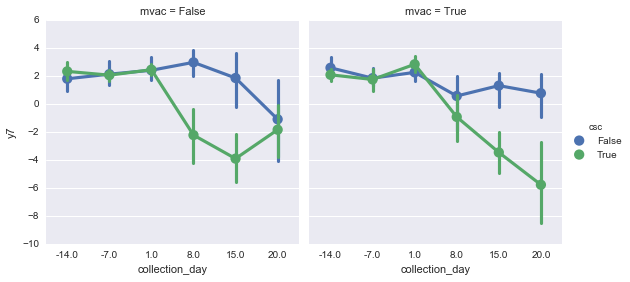

In [12]:
a = sns.factorplot(y=minb, x='collection_day', hue='csc', col='mvac', data=data)

One thing really interesting here, is that the CSC and SHC balances converge again when MVAC is not applied, but continue to diverge when MVAC is applied.  This suggests that the ratio of Helicobacter associate balance stabilizes and returns to the normal state when M. vaccae is not applied.  Whereas the M. vaccae is applied, the CSC and SHC balances continue to diverge.

In [13]:
def layout(node):
    """
    Specifies the layout for the ete.TreeStyle object.
    Parameters
    ----------
    node: ete.Tree
        Input node for specifying which attributes.
    """
    if node.is_leaf():
        # Add node name to leaf nodes
        taxa = ';'.join(taxonomy.loc[node.name].values) + '(%s)' % node.name
        node.taxa = taxa
        N = AttrFace("taxa", fsize=15, fgcolor='black')
        N.background.opacity = 0.3
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight, color="Red", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.7
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")
        fsize = 14
        fgcolor='black'           
        N = AttrFace("name", fsize=fsize, fgcolor=fgcolor)
        faces.add_face_to_node(N, node, 0)

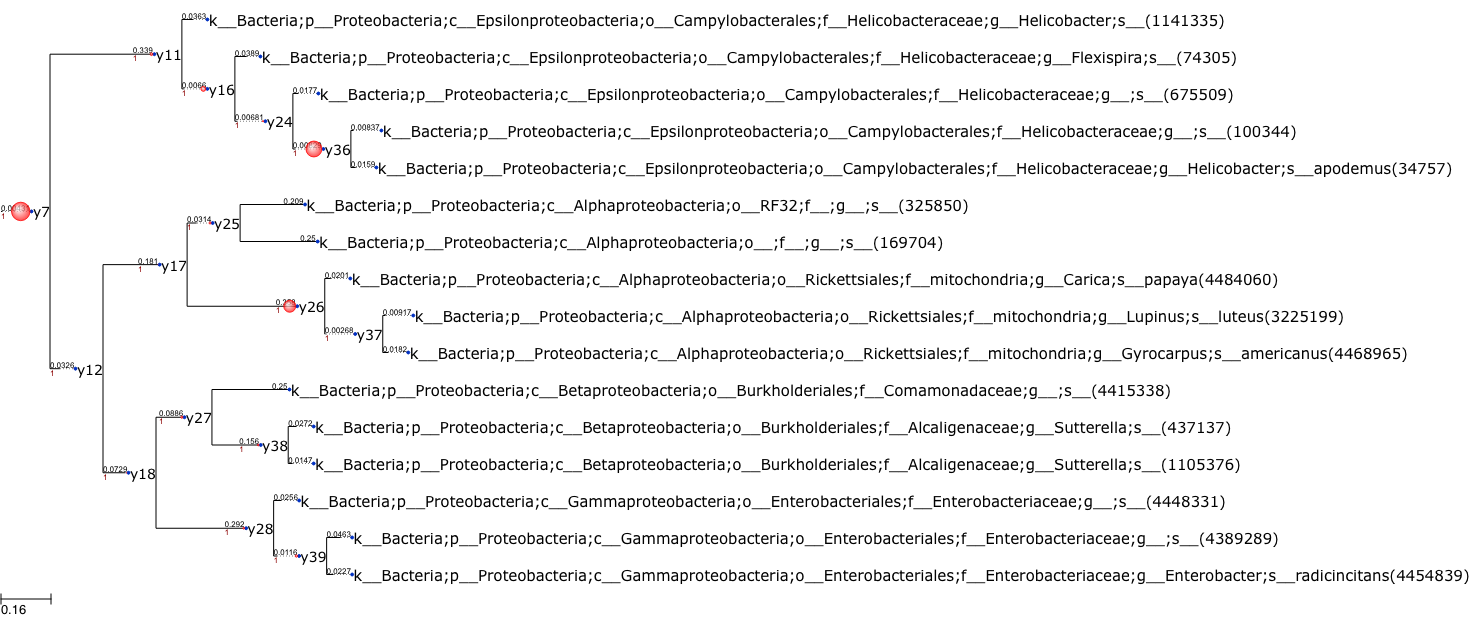

In [14]:
# Convert the p-values to negative log for better visualization.
column_name = "C(csc)[T.True]"
p = -np.log(sub_pvals[column_name].astype(np.float))

# Plot the balances for the subtree.
tr, ts = balanceplot(balances=p, tree=subtree, mode='r', layout=layout)  
ts.branch_vertical_margin = 20
tr.render(file_name='%%inline', tree_style=ts) 

As shown here, the `y7` balance represents the ratio of Helicobacter compared to alpha, beta and gamma proteobacteria.
More precisely it is

$$y7 = K \frac{g(\alpha,\beta,\gamma)}{g(\epsilon)}$$

where $K$ is a normalization constant, $\epsilon$ is the Episilon proteobacteria phyla, $\alpha$ is the Alpha proteobacteria phyla, $\beta$ is the Beta proteobacteria phyla and $\gamma$ is the Gamma proteobacteria phyla observed in this study.  And $g(x)$ is the geometric mean of the OTU abundances observed in $x$. It is important to note that these are geometric means of OTUs abundances contained within these phyla, not collapsed phyla abundances.

So in the time series plots shown above, there is a blooming of Helicobacter compared to the other Proteobacteria phyla, and this blooming continues with the M. vaccae treatment. However, when M. vaccae is not applied, this blooming halts and actually converges back to the control state.  Contrary to what was found in this study, M. vaccae could actually be detrimental, rather than beneficial. 

In [15]:
minb='y4'

In [16]:
# extract the subtree with significant hit
subtree = nodes[minb] 

# grab all OTUs in the subtree
tips = [n.name for n in subtree.tips()]

# get all balances within that subtree
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]

# grab all of those pvalues
sub_pvals = res.pvalues.loc[non_tips]

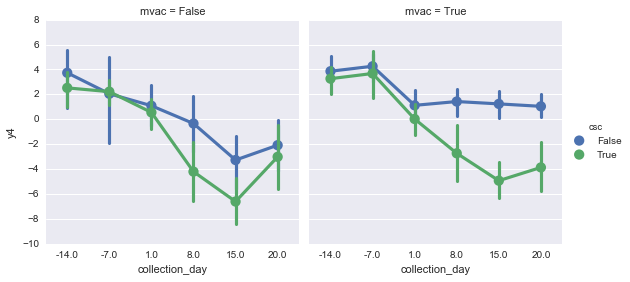

In [17]:
a = sns.factorplot(y='y4', x='collection_day', hue='csc', col='mvac', data=data)

In conclusion, balance trees are able to reproduce the main effects observed in this study.  In addition, it was able to identify patterns that were not previously observed before, and even suggests an alternative hypothesis contrary to the main conclusion from that study.

There are many ways to visualize the results from balance trees.  The nodes can be cached and queried to investigate the individual balances.  Customized layouts can be supplied to ETE for easy visualization of the internal nodes, as well as the leaves.  Finally, always be wary of whatever pvalues are returned from the model.  Make sure to treat these pvalues are explatory tools rather than an end goal.  Rather that p-values gives information about false positives, but does not give information about effect size.